<a href="https://colab.research.google.com/github/OscarRojasG/OCR/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento de imágenes

Las siguientes funciones tienen como objetivo detectar los contornos de las líneas, palabras y letras de cada imagen.

Librerías necesarias

In [7]:
import cv2
import numpy as np
from PIL import Image as Img
from sklearn.cluster import KMeans

Preprocesamiento de la imagen (difuminación, recolor, etc).

In [8]:
def preprocess_image(filename):
    img = cv2.imread(filename)
    img = img.astype("uint8")

    # Convertir a escala de grises
    preimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Contar cantidad de pixeles blancos
    white_px = np.sum(preimg == 255)

    # Si pixeles blancos < 50%, letra es blanca, no invertir colores!
    if white_px < preimg.size//2:
        preimg = cv2.threshold(preimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    else:
        preimg = cv2.threshold(preimg, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    return img, preimg

Funciones para obtener los contornos (*bounding box*)

In [9]:
def get_line_dilation(line_contour):
    # Dilatar línea verticalmente para eliminar acentos
    h = line_contour.shape[0]
    line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2*h))
    line_dilate = cv2.dilate(line_contour, line_kernel, iterations=1)

    # Obtener letras de la línea
    letters = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    letters = letters[0]

    # Si hay una letra, no dilatar
    if len(letters) == 1: return 1

    # Ordenar letras por coordenada X de menor a mayor
    sorted_letters = sorted(letters, key=lambda x: cv2.boundingRect(x)[0])

    # Obtener distancia entre letras consecutivas
    d = []
    for i in range(len(letters)-1):
        x1, y1, w1, h1 = cv2.boundingRect(sorted_letters[i])
        x2, y2, w2, h2 = cv2.boundingRect(sorted_letters[i+1])
        d.append(x2-(x1+w1))

    # Si hay dos letras, considerar ambas como una palabra...
    if len(letters) == 2: return d[0] + 1

    d = np.array(d).reshape(-1, 1)

    # Separar distancia en 2 grupos: distancias cortas (letras) y largas (palabras)
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    kmeans.fit(d)

    centroids = kmeans.cluster_centers_
    min_centroid = np.argmin(centroids)

    letter_distances = d[kmeans.labels_ == min_centroid]
    letter_distances = letter_distances.ravel()

    # Usar distancia máxima entre letras para calcular dilatación óptima
    max_letter_distance = max(letter_distances)
    optimal_dilation = max_letter_distance + 1
    return optimal_dilation


def get_contours(image_contour):
    # Mapa para guardar contornos
    contours = dict()

    image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2*image_contour.shape[1], 1))
    image_dilate = cv2.dilate(image_contour, image_kernel, iterations=1)

    # Obtener líneas
    lines = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lines = lines[0]

    # Procesar cada línea
    for l, line in enumerate(lines):
        contours[l] = dict()
        contours[l]['cntr'] = line
        contours[l]['words'] = dict()

        x, y, w, h = cv2.boundingRect(line)
        line_contour = image_contour[y:y+h, x:x+w]

        line_dilation = get_line_dilation(line_contour)
        line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (line_dilation, 2*h))
        line_dilate = cv2.dilate(line_contour, line_kernel, iterations=1)

        # Obtener palabras
        words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        words = words[0]

        # Procesar cada palabra
        for w, word in enumerate(words):
            contours[l]['words'][w] = dict()
            contours[l]['words'][w]['cntr'] = word
            contours[l]['words'][w]['letters'] = dict()

            xw, yw, ww, hw = cv2.boundingRect(word)
            word_contour = line_contour[yw:yw+hw, xw:xw+ww]

            word_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2*hw))
            word_dilate = cv2.dilate(word_contour, word_kernel, iterations=1)

            # Obtener letras
            letters = cv2.findContours(word_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            letters = letters[0]

            # Procesar cada letra
            for c, letter in enumerate(letters):
                xc, yc, wc, hc = cv2.boundingRect(letter)
                letter_contour = image_contour[y+yw+yc:y+yw+yc+hc, x+xw+xc:x+xw+xc+wc]

                # Encontrar fragmentos de letra (puntos, acentos, etc)
                fragments = cv2.findContours(letter_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                fragments = fragments[0]

                # Guardar coordenadas mínimas y máximas para unir fragmentos
                xf, yf, wf, hf = cv2.boundingRect(fragments[0])
                xf1, xf2, yf1, yf2 = xf, xf + wf, yf, yf + hf

                for fragment in fragments[1:]:
                    xf, yf, wf, hf = cv2.boundingRect(fragment)

                    if xf < xf1: xf1 = xf
                    if yf < yf1: yf1 = yf
                    if xf + wf > xf2: xf2 = xf + wf
                    if yf + hf > yf2: yf2 = yf + hf

                # Obtener contorno mínimo
                letter_min = np.array([(xf1, yf1), (xf2, yf1), (xf2, yf2), (xf1, yf2)], dtype=np.int32)

                # Guardar letra (contorno externo e interno)
                contours[l]['words'][w]['letters'][c] = dict()
                contours[l]['words'][w]['letters'][c]['cntr'] = letter
                contours[l]['words'][w]['letters'][c]['min_cntr'] = letter_min

    return contours

Redimensionar imagen.

In [10]:
def resize_image(image):
    height, width = image.shape
    ratio = height/width

    left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0

    if ratio > 2:
        pad = int(height/2) - width
        left_pad = pad//2
        right_pad = pad//2 + pad%2

    if ratio < 0.5:
        pad = int(width/2) - height
        top_pad = pad//2
        bottom_pad = pad//2 + pad%2

    padding = cv2.copyMakeBorder(image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT)
    resized = cv2.resize(padding, (20,20))
    return resized

Mostrar la imagen.

In [11]:
from io import BytesIO
from IPython.display import display, Image

def show_image(image):
    img = Img.fromarray(image)
    bio = BytesIO()
    img.save(bio, format='jpeg')
    return display(Image(bio.getvalue(), format='jpeg'))

Dibujar los contornos si se desea.

Esto es solo con propósitos ilustrativos o *debug*, no es necesario para la predicción.

In [12]:
def draw_contours(image, contours, draw_lines=True, draw_words=True, draw_letters=True):
    img_lines = image.copy()
    img_words = image.copy()
    img_letters = image.copy()

    for line in contours.keys():
        # Dimensiones de la línea respecto a la imagen
        x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

        # Dibujar linea
        cv2.rectangle(img_lines, (x,y), (x+w, y+h), (36,12,255), 2)

        for word in contours[line]['words'].keys():
            # Dimensiones de la palabra respecto a la línea
            xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

            # Dibujar palabra
            cv2.rectangle(img_words, (x+xw,y+yw), (x+xw+ww, y+yw+hw), (255,36,12), 2)

            for letter in contours[line]['words'][word]['letters'].keys():
                # Dimensiones de la letra respecto a la palabra
                xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

                # Dimensiones del contorno interno respecto al externo
                xm, ym, wm, hm = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['min_cntr'])

                # Dibujar contorno mínimo
                cv2.rectangle(img_letters, (x+xw+xc+xm,y+yw+yc+ym), (x+xw+xc+xm+wm, y+yw+yc+ym+hm), (36,255,12), 1)

    if draw_lines: show_image(img_lines)
    if draw_words: show_image(img_words)
    if draw_letters: show_image(img_letters)

# Crear dataset

El primer paso es subir las imágenes en una carpeta llamada *dataset*.

Las imágenes deben tener 79 caracteres, todas con el mismo orden.

In [ ]:
import string

chars = string.ascii_lowercase + string.ascii_uppercase + '1234567890,;:?!.@#$%&(){}[]'
print(chars)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890,;:?!.@#$%&(){}[]


Si las imágenes y funciones de procesamiento fueron bien cargadas, se debería poder ejecutar esta celda.

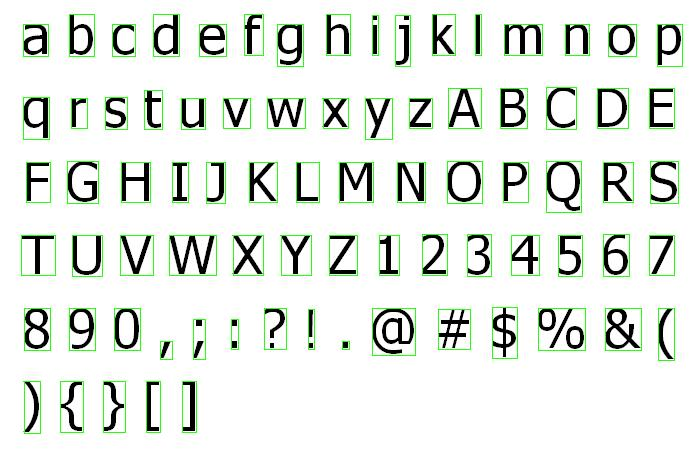

In [ ]:
complete_path = 'dataset/1.png'

img, preimg = preprocessing_image(complete_path)
contours = get_contours(preimg)
draw_contours(img, contours, False, False, True)

La siguiente función se encarga de guardar los pixeles de cada letra en el dataset, respetando el orden en que aparecen en la imagen.

In [ ]:
import numpy as np

def save_data(df, preimg, contours):
    letter_idx = 0

    # Ordenar líneas de arriba a abajo
    lines = sorted(contours.keys(), key=lambda x: cv2.boundingRect(contours[x]['cntr'])[1])

    for line in lines:
        # Dimensiones de la línea respecto a la imagen
        x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

        # Ordenar palabras de izquierda a derecha
        words = sorted(contours[line]['words'].keys(), key=lambda x: cv2.boundingRect(contours[line]['words'][x]['cntr'])[0])

        for word in words:
            # Dimensiones de la palabra respecto a la línea
            xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

            # Ordenar letras de izquierda a derecha
            letters = sorted(contours[line]['words'][word]['letters'].keys(), key=lambda x: cv2.boundingRect(contours[line]['words'][word]['letters'][x]['cntr'])[0])

            for letter in letters:
                # Dimensiones del contorno externo respecto a la palabra
                xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

                # Dimensiones del contorno interno respecto al contorno externo
                xm, ym, wm, hm = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['min_cntr'])

                # Obtener imagen
                letter_img = preimg[y+yw+yc+ym:y+yw+yc+ym+hm, x+xw+xc+xm:x+xw+xc+xm+wm]

                # Redimensionar imagen
                resized = resize_image(letter_img)

                # Convertir a arreglo
                image_arr = np.ravel(resized)

                # Guardar imagen en dataset
                row = np.insert(image_arr, 0, letter_idx)
                df.loc[len(df)] = row
                letter_idx += 1

Cargar el dataset excluyendo las imágenes donde falla la detección de los contornos.

In [ ]:
import pandas as pd
import os

path = "dataset"
skip = ["5.png", "6.png", "24.png"] # Imágenes con errores en procesamiento

# Crear dataset
df = pd.DataFrame(columns=np.arange(401))

# Recorrer archivos en la ruta
for file in os.listdir(path):
    ext = os.path.splitext(file)[1]

    # Solo archivos con extensión png
    if ext == ".png" and file not in skip:
        complete_path = os.path.join(path, file)

        # Preprocesar imágenes y obtener contornos
        img, preimg = preprocessing_image(complete_path)
        contours = get_contours(preimg)

        # Redimensionar letras y guardarlas en el dataset
        save_data(df, preimg, contours)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0,0,29,76,76,76,76,188,255,255,...,0,0,0,0,0,0,0,0,0,0
1,1,255,255,255,255,0,0,0,0,0,...,140,18,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,76,76,...,76,76,76,75,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,76,76,250,...,76,76,76,21,0,0,0,0,0,0


Exportar el dataset en un archivo csv.

In [ ]:
df.to_csv('dataset.csv', header=False, index=False)

# Importar dataset y crear modelo

In [13]:
import pandas as pd

df = pd.read_csv("dataset.csv", header=None, dtype=np.uint8)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0,0,29,76,76,76,76,188,255,255,...,0,0,0,0,0,0,0,0,0,0
1,1,255,255,255,255,0,0,0,0,0,...,140,18,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,76,76,...,76,76,76,75,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,76,76,250,...,76,76,76,21,0,0,0,0,0,0


Separación en datos de entrenamiento y prueba.

In [14]:
from sklearn.model_selection import train_test_split

Y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

Creación y entrenamiento del modelo

In [15]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Dense(250, activation='sigmoid', input_shape=(400,)))
model.add(layers.Dense(79, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
54/54 [==============================] - 1s 9ms/step - loss: 3.9430 - accuracy: 0.1553
Epoch 2/100
54/54 [==============================] - 0s 8ms/step - loss: 2.8864 - accuracy: 0.4830
Epoch 3/100
54/54 [==============================] - 0s 8ms/step - loss: 2.1655 - accuracy: 0.6794
Epoch 4/100
54/54 [==============================] - 0s 8ms/step - loss: 1.6617 - accuracy: 0.7708
Epoch 5/100
54/54 [==============================] - 0s 9ms/step - loss: 1.2824 - accuracy: 0.8265
Epoch 6/100
54/54 [==============================] - 0s 8ms/step - loss: 1.0584 - accuracy: 0.8505
Epoch 7/100
54/54 [==============================] - 0s 7ms/step - loss: 0.8960 - accuracy: 0.8669
Epoch 8/100
54/54 [==============================] - 0s 8ms/step - loss: 0.7714 - accuracy: 0.8875
Epoch 9/100
54/54 [==============================] - 0s 7ms/step - loss: 0.6426 - accuracy: 0.9009
Epoch 10/100
54/54 [==============================] - 0s 7ms/step - loss: 0.5705 - accuracy: 0.9074
Epoch 11/

Validación con datos de prueba.

In [16]:
model.evaluate(X_test, Y_test, verbose=False)

[0.2381470650434494, 0.9063231945037842]

Predecir el caracter de una imagen.

In [17]:
import string

chars = string.ascii_lowercase + string.ascii_uppercase + '1234567890,;:?!.@#$%&(){}[]'

def predict(image, verbose=False):
    prob = model.predict(np.array([image]), verbose=False)
    pred = np.argmax(prob)
    letter = chars[pred]

    if verbose:
        print(letter)
        image = np.reshape(image, (20,20))
        show_image(image)
        print("----------")

    return letter

Predecir caracteres de una imagen a partir del mapa de contornos.

In [18]:
def predict_text(image, contours, verbose=False):
    text = ""

    # Ordenar líneas de arriba a abajo
    lines = sorted(contours.keys(),
                key=lambda x: cv2.boundingRect(contours[x]['cntr'])[1])

    for line in lines:
        # Dimensiones de la línea respecto a la imagen
        x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

        # Ordenar palabras de izquierda a derecha
        words = sorted(contours[line]['words'].keys(),
                    key=lambda x: cv2.boundingRect(contours[line]['words'][x]['cntr'])[0])

        for word in words:
            # Dimensiones de la palabra respecto a la línea
            xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

            # Ordenar letras de izquierda a derecha
            letters = sorted(contours[line]['words'][word]['letters'].keys(),
                            key=lambda x: cv2.boundingRect(contours[line]['words'][word]['letters'][x]['cntr'])[0])

            for letter in letters:
                # Dimensiones del contorno externo respecto a la palabra
                xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

                # Dimensiones del contorno interno respecto al externo
                xm, ym, wm, hm = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['min_cntr'])

                # Dimensiones de la letra respecto a la imagen
                letter_img = image[y+yw+yc+ym:y+yw+yc+ym+hm, x+xw+xc+xm:x+xw+xc+xm+wm]

                # Redimensionar letra
                resized = resize_image(letter_img)

                # Convertir matriz a arreglo
                image_arr = np.ravel(resized)

                # Predecir letra
                letter = predict(image_arr, verbose)
                text += letter

            text += " "

        text += "\n"

    return text

Función general para predecir el texto de una imagen.

In [19]:
def get_text(filename, verbose=True):
    img, preimg = preprocess_image(filename)
    contours = get_contours(preimg)
    if verbose: draw_contours(img, contours)

    return predict_text(preimg, contours)

# Ejemplos

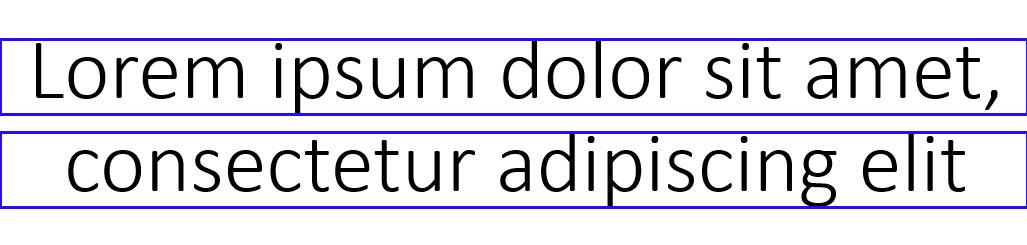

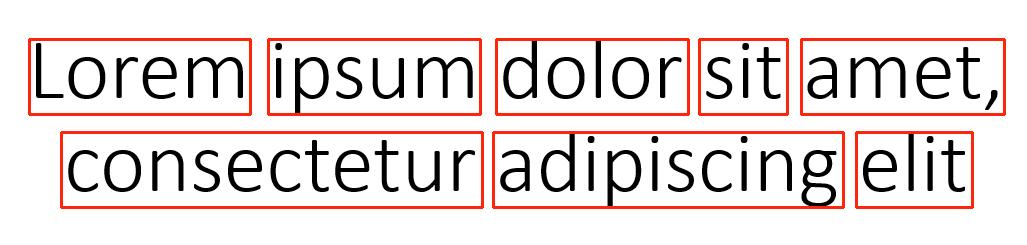

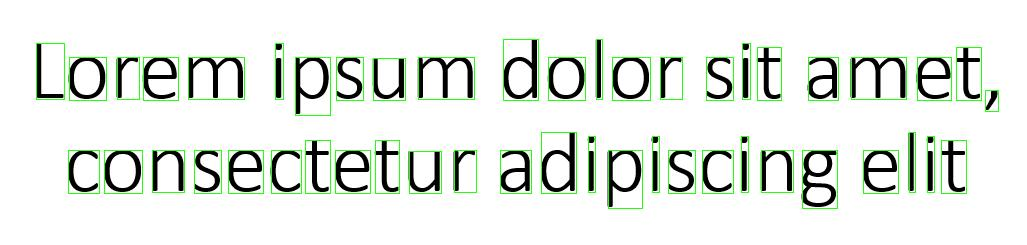

LOrem ipSUm dOlOr Sit amet, 
COnSeCtetUr adipiSCing eJit 



In [20]:
text = get_text("example.png")
print(text)

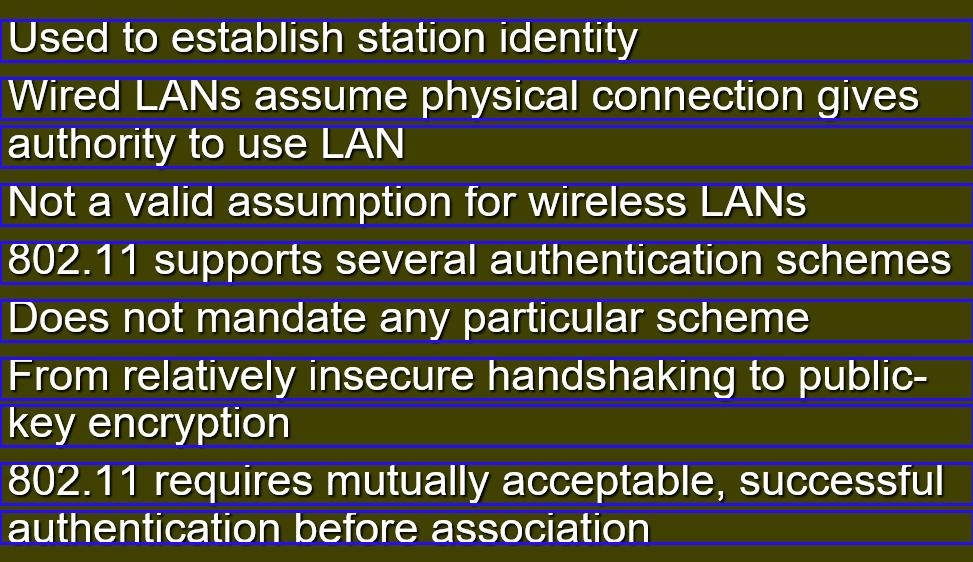

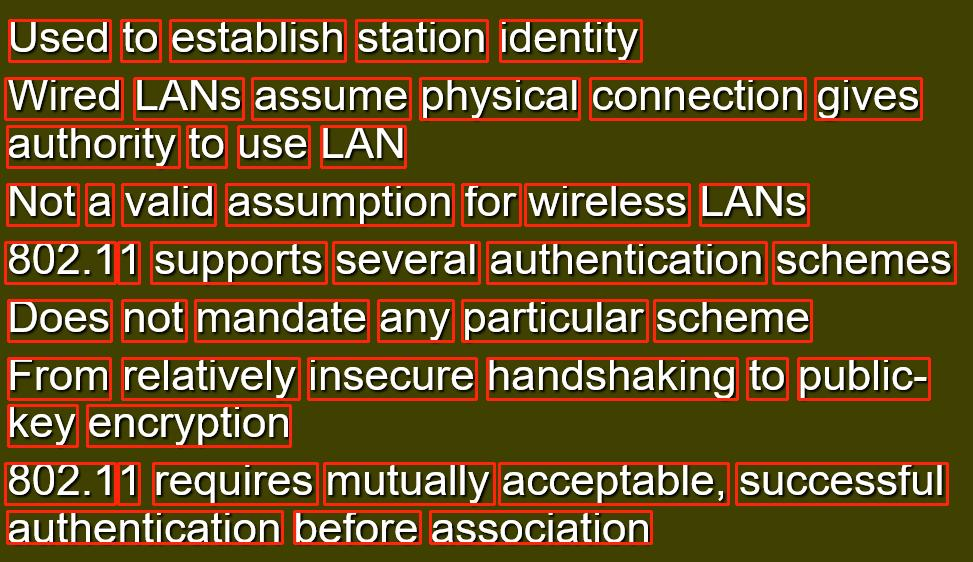

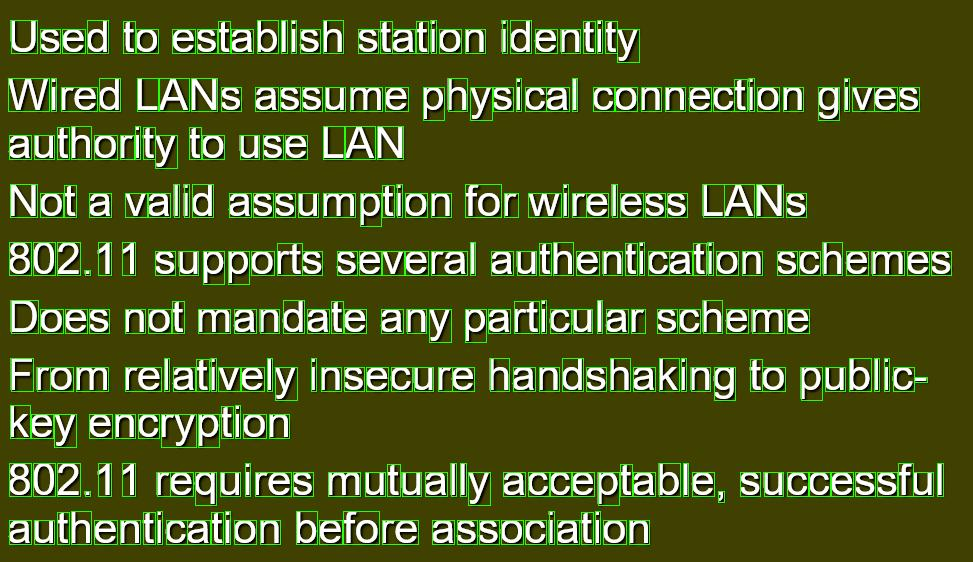

Used to establish station identity 
Wimd LANs assume physicaI connection gives 
authority to use LAN 
Not a vaIid assumption mr wireIess LANs 
8O2.1 1 suppods sevemI authentication schemes 
Does not mandate any padicuIar scheme 
From mIativeIy insecure handshaking to pubIic, 
key enclption 
8O2.1 1 requims mutuaIly acceptabIe, successful 
authentication bemm association 



In [21]:
text = get_text("example2.png")
print(text)

# Experimentos

Relación dilatación (horizontal) y bounding box ;)

In [ ]:
def get_dilation_variation(filename, iterations=10):
    left_var = []
    right_var = []

    img = cv2.imread(filename)
    img.astype("uint8")
    Img.fromarray(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Img.fromarray(gray)

    blur = cv2.GaussianBlur(gray, (7,7), 0)
    Img.fromarray(blur)

    image_contour = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    Img.fromarray(image_contour)

    words = cv2.findContours(image_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    words = words[0]
    x, y, w, h = cv2.boundingRect(words[0])

    for dilation in range(1, iterations+1):
        image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilation, 1))
        image_dilate = cv2.dilate(image_contour, image_kernel, iterations=1)
        Img.fromarray(image_dilate)

        words = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        words = words[0]

        xd, yd, wd, hd = cv2.boundingRect(words[0])
        left_var.append(x-xd)
        right_var.append(xd+wd-x-w)

    return left_var, right_var

In [ ]:
get_dilation_variation("A_small.png")

([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

In [ ]:
get_dilation_variation("A_medium.png")

([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

In [ ]:
get_dilation_variation("A_big.png")

([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

La dilatación es independiente del tamaño de la imagen!

Según el experimento, una dilatación $X$ ensancha la imagen $(X-1)/2$ pixeles a cada lado (izquierda y derecha).

A partir de esto, podemos calcular la separación óptima entre palabras de una línea con el siguiente algoritmo:

1. Calcular las coordenadas de las letras.

2. Ordenar letras por coordenada $x$ de menor a mayor.

3. Calcular la distancia entre letras consecutivas y guardarlas en un arreglo $D$.

4. Agrupar las distancias en dos clústeres $D_1$ y $D_2$

5. Utilizar distancia $\max(D_1)$ para calcular la dilatación mínima necesaria para separar cada palabra...

La dilatación mínima para rellenar la distancia $\max(D_1)$ es $X = \max(D_1)+1$


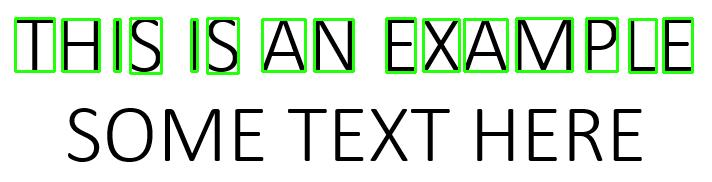

[8, 15, 10, 30, 10, 24, 9, 33, 8, 5, 9, 14, 12, 7]


In [ ]:
img = cv2.imread('example.png')
img.astype("uint8")
Img.fromarray(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Img.fromarray(gray)

blur = cv2.GaussianBlur(gray, (7,7), 0)
Img.fromarray(blur)

image_contour = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
Img.fromarray(image_contour)

# Paso 0: obtener líneas
image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
image_dilate = cv2.dilate(image_contour, image_kernel, iterations=5)

lines = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
line = lines[0][1] # Trabajaremos solo con línea 0 por simplicidad...

x, y, w, h = cv2.boundingRect(line)
line_contour = image_contour[y:y+h, x:x+w]

# Paso 1
letters = cv2.findContours(line_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
letters = letters[0]

img2 = img.copy()
for letter in letters:
    xc, yc, wc, hc = cv2.boundingRect(letter)
    cv2.rectangle(img2, (x+xc,y+yc), (x+xc+wc, y+yc+hc), (36,255,12), 2)

show_image(img2)

# Paso 2
sorted_letters = sorted(letters, key=lambda x: cv2.boundingRect(x)[0])

# Paso 3
d = []
for i in range(len(letters)-1):
    x1, y1, w1, h1 = cv2.boundingRect(sorted_letters[i])
    x2, y2, w2, h2 = cv2.boundingRect(sorted_letters[i+1])
    d.append(x2-(x1+w1))

print(d)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Paso 4
d = np.array(d).reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(d)

centroids = kmeans.cluster_centers_
min_centroid = np.argmin(centroids)

letter_distances = d[kmeans.labels_ == min_centroid]
letter_distances = letter_distances.ravel()
print("Separaciones letras:", letter_distances)

word_distances = d[kmeans.labels_ == (1 - min_centroid)]
word_distances = word_distances.ravel()
print("Separaciones palabras:", word_distances)

Separaciones letras: [ 8 15 10 10  9  8  5  9 14 12  7]
Separaciones palabras: [30 24 33]


In [ ]:
# Paso 5
max_letter_distance = max(letter_distances)
optimal_dilation = max_letter_distance + 1
optimal_dilation

16

Veamos... :)

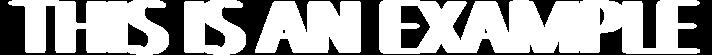

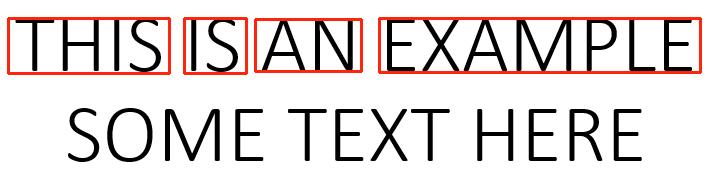

In [ ]:
x, y, w, h = cv2.boundingRect(line)
line_contour = image_contour[y:y+h, x:x+w]

line_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (optimal_dilation, 1))
line_dilate = cv2.dilate(line_contour, line_kernel, iterations=1)

show_image(line_dilate)

# Paso 1
words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
words = words[0]

img2 = img.copy()
for word in words:
    xw, yw, ww, hw = cv2.boundingRect(word)
    cv2.rectangle(img2, (x+xw,y+yw), (x+xw+ww, y+yw+hw), (255,36,12), 2)

show_image(img2)

Perfecto... y si restamos 1 a la dilatación "óptima"?

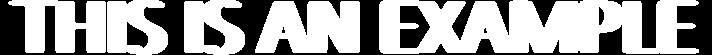

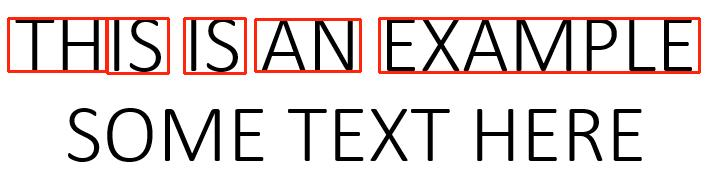

In [ ]:
x, y, w, h = cv2.boundingRect(line)
line_contour = image_contour[y:y+h, x:x+w]

line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (optimal_dilation-1, 1))
line_dilate = cv2.dilate(line_contour, line_kernel, iterations=1)

show_image(line_dilate)

# Paso 1
words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
words = words[0]

img2 = img.copy()
for word in words:
    xw, yw, ww, hw = cv2.boundingRect(word)
    cv2.rectangle(img2, (x+xw,y+yw), (x+xw+ww, y+yw+hw), (255,36,12), 2)

show_image(img2)

Hay 2 contornos en la primera palabra, por lo tanto no nos sirve ;)

# Entorno para experimentos

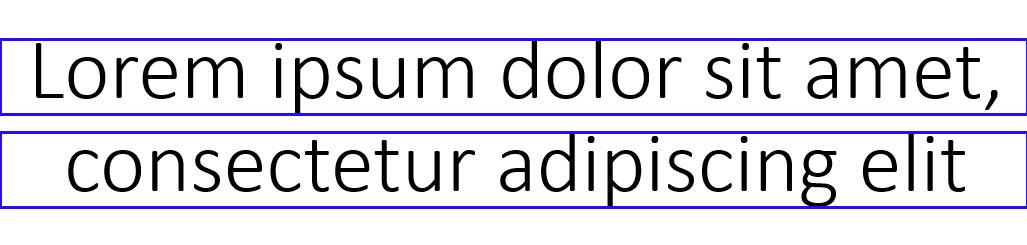

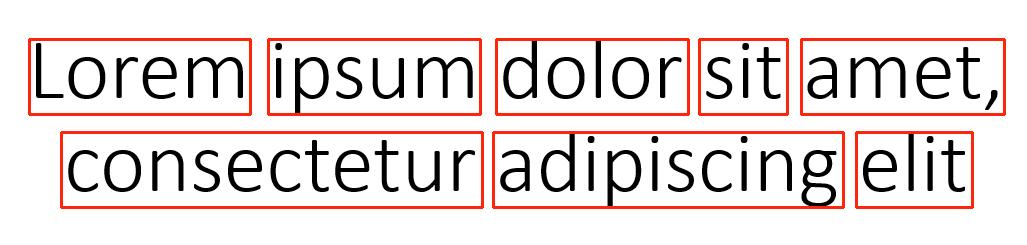

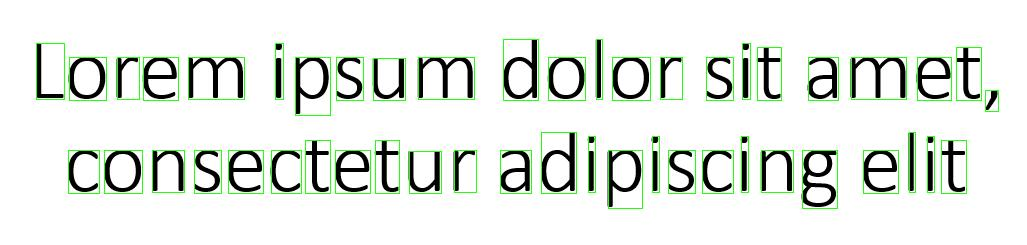

In [23]:
filename = "example.png"

img, preimg = preprocess_image(filename)
contours = get_contours(preimg)
draw_contours(img, contours)

In [24]:
text = predict_text(preimg, contours, True)

L


----------
O


----------
r


----------
e


----------
m


----------
i


----------
p


----------
S


----------
U


----------
m


----------
d


----------
O


----------
l


----------
O


----------
r


----------
S


----------
i


----------
t


----------
a


----------
m


----------
e


----------
t


----------
,


----------
C


----------
O


----------
n


----------
S


----------
e


----------
C


----------
t


----------
e


----------
t


----------
U


----------
r


----------
a


----------
d


----------
i


----------
p


----------
i


----------
S


----------
C


----------
i


----------
n


----------
g


----------
e


----------
J


----------
i


----------
t


----------


In [25]:
x = df[df.loc[:,0] == 40].reset_index(drop=True)

for i in range(10):
    arr = np.array(x.loc[i][1:])
    predict(arr, True)

O


----------
O


----------
O


----------
O


----------
O


----------
O


----------
o


----------
0


----------
O


----------
O


----------
